# Oscillations in an interneuron network
Oscillations are thought to play a critical role in coordinating brain activity and information transfer.
One potential mechanism for their generation is via delayed synaptic coupling in neuronal networks.

In this exercise you will implement a network of inhibitory interneurons driven by excitatory Poisson spiking and examine its dynamics.

In [1]:
# !pip install brian2

In [2]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt 
import scipy

## Task 0: testing your Brian implementation for a single neuron
Implement a single conductance-based leaky integrate-and-fire neuron in Brian!

The membrane potential is described by the following ODE:

\begin{align*}
C \frac{d}{dt}V(t) &= g_\mathrm{leak}(E_\mathrm{rest} - V(t)) + I_\mathrm{syn}(t) \\
I_\mathrm{syn}(t) &= g_e(t)\left(E_e-V(t)\right) + g_i(t)\left(E_i-V(t)\right)
\end{align*}

If $V$ exceeds a threshold $V_t$ it is reset to $V_r$ and remains fixed for a refractory period $\tau_\mathrm{ref}$.

The neuron can receive both excitatory and inhibitory input. For both types of synapses the postsynaptic conductance in response to a single presynaptic spike at time 0 should be modeled as a dual exponential:

\begin{align*}
g(t) &= g_\mathrm{peak}s\left[e^{-(t-\tau_l)/\tau_d} - e^{-(t-\tau_l)/\tau_r}\right]\Theta(t-\tau_l) \\
s &= \left(\text{max}\left(e^{-t/\tau_d} - e^{-t/\tau_r}\right)\right)^{-1}
= \left(\left(\frac{\tau_d}{\tau_r}\right)^{\frac{\tau_r}{\tau_r-\tau_d}}- \left(\frac{\tau_d}{\tau_r}\right)^{\frac{\tau_d}{\tau_r-\tau_d}}\right)^{-1} \quad \text{normalizing factor}
\end{align*}
where $\tau_l, \tau_r, \tau_d$ are the synaptic delay, rise time constant and decay time constant resp.

Analytically one can derive (*Bonus exercise) a set of ODEs describing $g(t)$ :

\begin{align*}
\dot{g}(t) &= \frac{-g+x}{\tau_d} \\
\dot{x}(t) &= -\frac{x}{\tau_r} \\
x(\tau_l) &= g_\mathrm{peak}s\frac{\tau_d - \tau_r}{\tau_r}\quad\text{ initial value}, x(t)=0 \text{ for } 0<t<\tau_l
\end{align*}

#### (a) Implement a single such neuron in Brian.
#### (b) Test your implementation of the conductance: 
Using either an inhibitory or excitatory synapse, connect your neuron to a single presynaptic unit that sends a single input spike. Plot the resulting conductance, synaptic current and membrane potential. Compare the numerical conductance trace to the analytical expression for $g(t)$ and check the peak conductances. <br>
Hints: Use Brian's "SpikeGeneratorGroup" (see tutorial). Identify the "on_pre" condition needed for the Brian synapse in the equations given above.

#### Use the following parameters:
\begin{align*}
g_\mathrm{leak} &= 10 \text{ nS} \\
C &= 100 \text{ pF} \\
E_\mathrm{rest} &=  -65\text{ mV} \\
E_e &=  0\text{ mV} \\
E_i &=  -75\text{ mV} \\
V_t &=  -52\text{ mV} \\
V_r &=  -67 \text{ mV} \\
\tau_\mathrm{ref} &= 1 \text{ ms} 
\end{align*}
Excitatory synapses:
\begin{align*}
\tau_l &= 1 \text{ ms} \\
\tau_r &= 0.5 \text{ ms} \\
\tau_d &= 2 \text{ ms} \\
g_\mathrm{peak} &= 1 \text{ nS} 
\end{align*}
Inhibitory synapses:
\begin{align*}
\tau_l &= 1 \text{ ms} \\
\tau_r &= 0.45 \text{ ms} \\
\tau_d &= 1.2 \text{ ms} \\
g_\mathrm{peak} &= 5 \text{ nS} 
\end{align*}

In [3]:
#### a) implementing the neuron
b2.start_scope()

gleak = 10*b2.nS
C = 100*b2.pF
Em = -65*b2.mV
Ee = 0*b2.mV
Ei = -75*b2.mV
Vt = -52*b2.mV
Vr = -67*b2.mV
tref = 1*b2.ms

#excitatory parameters
gepeak = 1*b2.nS
tde = 2*b2.ms
tre = 0.5*b2.ms
tle = 1*b2.ms

#inhibitory parameters
gipeak = 5*b2.nS
tdi = 1.2*b2.ms
tri = 0.45*b2.ms
tli = 1*b2.ms

 
se = ((tde/tre)**(tre/(tre-tde))-(tde/tre)**(tde/(tre-tde)))
si = ((tdi/tri)**(tri/(tri-tdi))-(tdi/tri)**(tdi/(tri-tdi)))

    
eqs= '''
dv/dt = (gleak*(Em - v) + Isyn)/C : volt (unless refractory)
Isyn = (ge*(Ee -v) + gi*(Ei-v)) : amp
dge/dt = (-ge + x_e)/tde : siemens
dx_e/dt = -x_e/tre : siemens
dgi/dt = (-gi + x_i)/tdi : siemens
dx_i/dt = -x_i/tri : siemens
'''
#initial x(tl)
J_e = gepeak * ((tde-tre)/tre)/se
J_i =gipeak*((tdi-tri)/tri)/si
x_e ='''
x_e += J_e
'''
x_i='''
x_i += J_i
'''


G = b2.NeuronGroup(1, eqs, method='euler', threshold='v>Vt', reset ='v = Vr', refractory=tref)
G.v = Em

#### b)Testing implementation of the conductance

Gexc = b2.NeuronGroup(2, eqs, method='euler', threshold='v>Vt', reset ='v = Vr',refractory=tref)
Gexc.v = Em

#sending a single input spike
times = [0*b2.ms]
indices = np.zeros(len(times))
SGG = b2.SpikeGeneratorGroup(1, indices, times)

#Excitatory Synapse 
Sexc = b2.Synapses(SGG, Gexc, on_pre= x_e, delay= tle)
Sexc.connect()

# State monitors
M = b2.StateMonitor(Gexc, ('v','Isyn', 'ge'), record=True) 
#spikemon = b2.SpikeMonitor(G)

#run
print('Before v = %s' % Gexc.v[0])
b2.run(100*b2.ms)
print('After v = %s' % Gexc.v[0])

Before v = -65. mV
After v = -64.99987088 mV


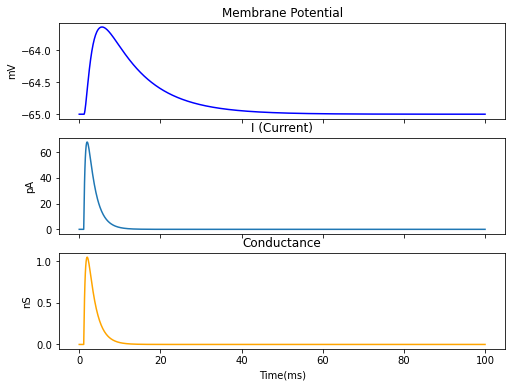

In [4]:
fig, ax = plt.subplots(3, sharex=True, figsize=(8,6))
ax[0].plot(M.t/b2.ms, M.v[1]/b2.mV, 'b')
ax[0].set(title = 'Membrane Potential', ylabel='mV')

ax[1].plot(M.t/b2.ms, M.Isyn[1]/b2.pA)
ax[1].set(title = 'I (Current)', ylabel='pA')

ax[2].plot(M.t/b2.ms, M.ge[1]/b2.nS, 'orange')
ax[2].set(title = 'Conductance', ylabel='nS', xlabel='Time(ms)');

WARNING    /Users/gonuni/opt/anaconda3/envs/brian2/lib/python3.6/site-packages/brian2/units/fundamentalunits.py:1025: UserWarning: Unknown ufunc 'heaviside' in __array_prepare__
  warn("Unknown ufunc '%s' in __array_prepare__" % uf.__name__)
 [py.warnings]
WARNING    /Users/gonuni/opt/anaconda3/envs/brian2/lib/python3.6/site-packages/brian2/units/fundamentalunits.py:1060: UserWarning: Unknown ufunc 'heaviside' in __array_wrap__
  warn("Unknown ufunc '%s' in __array_wrap__" % uf.__name__)
 [py.warnings]


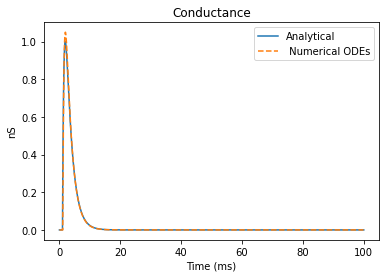

In [5]:
def ge(t):
        neg_exp = lambda tau : np.exp(-(t*b2.ms-tle)/tau)
        return gepeak * (neg_exp(tde) - neg_exp(tre)) * np.heaviside(t*b2.ms -tle, 0)/se
time = np.linspace(0,100, 10000) 
plt.plot(time,ge(time)/b2.nS, label = 'Analytical')
plt.plot(M.t/b2.ms, M.ge[1]/b2.nS, '--',label = ' Numerical ODEs', )
plt.gca().set(title='Conductance', xlabel ='Time (ms)', ylabel='nS')
plt.legend();

Comparing the numerical computed conductance to the analytical ($g(t)$) we can see both achieve peak conductance as 1 as expected from the value $gpeak=1nS$ we set up. If we observe close numerical peak conductance goes a bit higher than 1 but this difference is negligible 

## Task 1: Setting up the network
Create a network of 200 of the above described units. Introduce inhibitory synapses between the units with a connection probability of 20% (i.e. the units are inhibitory interneurons).

Adding excitatory drive: <br>
Create a second population of 8000 pyramidal cells that fire Poisson spike trains at a rate of 6Hz each (Hint: Brian "PoissonGroup"). Add excitatory synapses from this pyramidal cell population onto your interneuron network with a connection probability of 10%. <br>
Comprehension question: What is the total rate of excitatory input that a single interneuron receives on average?

Add State/Spike/PopulationRate Monitors as you see fit (see also task 2). Wrap all your code into one reusable function!

In [12]:
#Now we make our network fuction for next tasks
def network(Ninter, Npir, frates, runtime):
    b2.start_scope()

    gleak = 10*b2.nS
    C = 100*b2.pF
    Em = -65*b2.mV
    Ee = 0*b2.mV
    Ei = -75*b2.mV
    Vt = -52*b2.mV
    Vr = -67*b2.mV
    tref = 1*b2.ms

    #excitatory parameters
    gepeak = 1*b2.nS
    tde = 2*b2.ms
    tre = 0.5*b2.ms
    tle = 1*b2.ms

    #inhibitory parameters
    gipeak = 5*b2.nS
    tdi = 1.2*b2.ms
    tri = 0.45*b2.ms
    tli = 1*b2.ms


    se = ((tde/tre)**(tre/(tre-tde))-(tde/tre)**(tde/(tre-tde)))
    si = ((tdi/tri)**(tri/(tri-tdi))-(tdi/tri)**(tdi/(tri-tdi)))


    eqs= '''
    dv/dt = (gleak*(Em - v) + Isyn)/C : volt (unless refractory)
    Isyn = (ge*(Ee -v) + gi*(Ei-v)) : amp
    dge/dt = (-ge + x_e)/tde : siemens
    dx_e/dt = -x_e/tre : siemens
    dgi/dt = (-gi + x_i)/tdi : siemens
    dx_i/dt = -x_i/tri : siemens
    '''
    #initial x(tl)
    J_e = gepeak * ((tde-tre)/tre)/se
    J_i =gipeak*((tdi-tri)/tri)/si
    x_e ='''
    x_e += J_e
    '''
    x_i='''
    x_i += J_i
    '''

#Interneurons 

    Gint = b2.NeuronGroup(Ninter, eqs, method='euler', threshold='v>Vt', reset ='v = Vr', refractory=tref)
    Gint.v = Em

#Pyramidal Poisson Group
    Gpir = b2.PoissonGroup(Npir, rates=frates*b2.Hz)

#Interneuron Synapses
    Sint = b2.Synapses(Gint, Gint, on_pre= x_i, delay= tle)
    Sint.connect(p = 0.2)

#Pyramidal cells to Interneuon Synapses
    Spyr = b2.Synapses(Gpir, Gint, on_pre = x_e, delay= tle)
    Spyr.connect(p = 0.1)
    
# State monitors
    M = b2.StateMonitor(Gint, ('v','Isyn', 'ge', 'gi'), record=True) 
    spikemon = b2.SpikeMonitor(Gint)
    ratemon = b2.PopulationRateMonitor(Gint)


    #run
    b2.run(runtime*b2.ms)
    
    return M, spikemon, ratemon, runtime, frates

The total rate of excitatory input that a single interneuron receives is :
$$
6Hz(rate) * 0.1 (connectivity) * \frac{8000(pyramidal neurons)}{200(interneurons)}= 24 Hz
$$

## Task 2: Simulating and visualizing the network activity
Run your network simulation (pick a reasonable simulation time). 

(a) Show the interneuron network's spiking activity and population rate over time. In addition plot the membrane potential of one or two example interneurons. 

(b) How are the firing rates of individual interneurons distributed? 

(c) Quantify the regularity of interneuron firing using the coefficient of variation of interspike-intervals.

(Bonus) Simulate your network for at least 1050 ms (the longer the better). Use the function get_PSD(signal, dt) given below to calculate the power spectral density of the population rate and plot it. Hint: leave the keyword arguments of the function as they are, remember to provide the simulation time step in SECONDS!

Summarize your results to describe the network state that you observe.

In [13]:
statenet, spikenet, ratenet, runtime, frate6 = network(200, 8000, 6, 200)

WARNING    "dt" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 0.0001. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


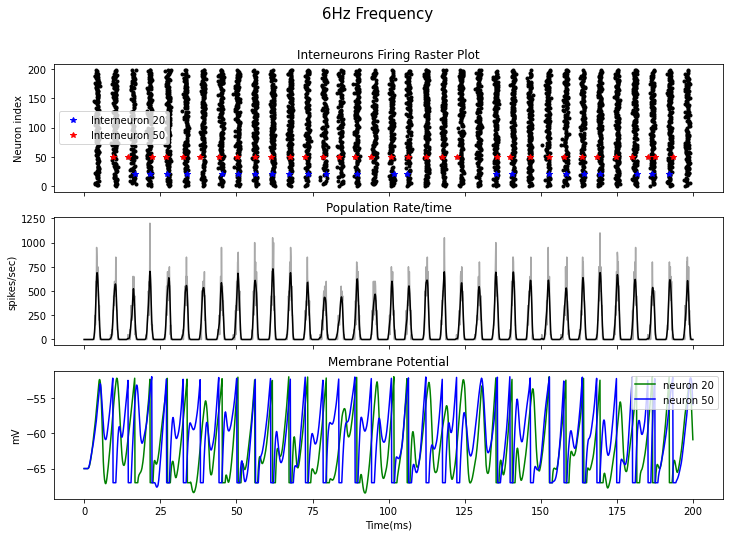

In [14]:
# we define a plotting fuction as we are going to repeat the task in task 3

def plotting(statenet, spikenet, ratenet, runtime, frates):
    fig, ax = plt.subplots(3, sharex=True, figsize=(12,8))
    ax[0].plot(spikenet.t/b2.ms, spikenet.i, '.k')
    ax[0].plot(spikenet.t[spikenet.i==20]/b2.ms, spikenet.i[spikenet.i==20], '*b', label = 'Interneuron 20')
    ax[0].plot(spikenet.t[spikenet.i==50]/b2.ms, spikenet.i[spikenet.i==50], '*r', label = 'Interneuron 50')
    ax[0].set(title = 'Interneurons Firing Raster Plot', ylabel='Neuron index')
    ax[0].legend()
    
    ax[1].plot(ratenet.t/b2.ms, ratenet.rate/b2.Hz, 'darkgrey')
    ax[1].plot(ratenet.t/b2.ms, ratenet.smooth_rate(width=.2*b2.ms)/b2.Hz, 'k')
    ax[1].set(title = 'Population Rate/time', ylabel='spikes/sec)')

    ax[2].plot(statenet.t/b2.ms, statenet.v[20]/b2.mV, 'g', label= 'neuron 20')
    ax[2].plot(statenet.t/b2.ms, statenet.v[50]/b2.mV, 'b', label= 'neuron 50')
    ax[2].set(title = 'Membrane Potential', ylabel='mV', xlabel='Time(ms)');
    ax[2].legend()
    
    plt.suptitle(str(frates) + 'Hz Frequency', size = 15)
    
    
sixHzFRnt = plotting(statenet, spikenet, ratenet, runtime, frate6)

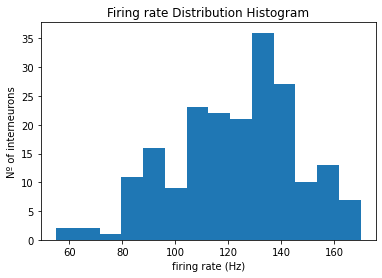

The mean of interneurons FR is 123.15Hz
The coefficient of variation of interspike-intervals is 0.23


In [37]:
def firing_rates_dis(spikenet, runtime, nbins):
    #plotting an histogram for visualize interneuron's firing rate distribution
    INfr = spikenet.count/runtime
    plt.hist(INfr*1000 , bins = nbins)
    plt.gca().set(title = 'Firing rate Distribution Histogram', xlabel= 'firing rate (Hz)', ylabel='Nº of interneurons')
    plt.show()
    #coefficient of variation of interspike-intervals
    spikeintervals = 1/INfr
    spikeintervalslen = spikeintervals.shape[0]
    for i in np.arange(spikeintervalslen):
        if spikeintervals[i-1] == float("inf"):
            spikeintervals[i-1] = 1e-12
    cv = np.std(spikeintervals)/np.mean(spikeintervals)
    print("The mean of interneurons FR is " +str(np.mean(INfr*1000))+"Hz")
    print("The coefficient of variation of interspike-intervals is " + str(np.round(cv,2)))
    return cv
    
cvSINt= firing_rates_dis(spikenet, runtime, 14)

We can see the firing rate distribution of our interneuron network above.

In [56]:
statenetlong, spikenetlong, ratenetlong, runtimelong, frate6long = network(200, 8000, 6, 1050)


  Now using 1.0 out of 1.05 signal seconds for PSD calculation (df=1Hz, k=1)


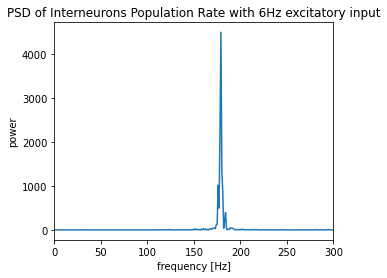

In [61]:
def get_fft(signal, dt):
  ''' 
  returns scipy fast fourier transform with correction for the time step dt
  dt: [sec]
  '''
  return dt*scipy.fft.fft(signal)

def get_PSD(signal, dt, df=1, offset=0.05, subtract_mean=True, eps=0.1):
    """
    Computes the power spectral density of the signal
    Input:
        signal: [Hz] typically the population rate
        dt: [sec] simulation time step
        df: [Hz] desired frequency resolution of the PSD
        offset: [sec] signal in the time interval [0, offset] is removed before doing the Fourier transform. 
                Use this parameter to ignore the initial transient signals of the simulation.
        subtract_mean (bool): If true, the mean value of the signal is subtracted.

    Returns:
        freqs: range of frequencies for which psd is given (resolution: df)
        psd:   averaged power spectral density for the frequency range given by freqs
    """
    
    f_max = np.around(1/(2 * dt)) # maximal frequency of PSD
    N_init = int(offset/dt) # offset in array steps
    N_snippet = int(2 * f_max / df) # required length of one snippet for resolution df (in array length)
    N_signal = len(signal)
    T_snippet = N_snippet*dt # length of snippets in units of time [seconds]
    k = N_signal//N_snippet # see how many snippets we can average given the signal length
    N_required = k * N_snippet + N_init
    
    # crop the signal if necessary
    if not k or (N_signal < N_required):
        raise ValueError('Signal length not sufficient for PSD calculation, simulate for at least {:.2f}seconds!'.format(T_snippet+offset))
    if N_signal > N_required:
        print("PSD: drop samples")
        signal = signal[:N_required]
    signal = signal[N_init:]
    print("\n  Now using {} out of {:.2f} signal seconds for PSD calculation (df={}Hz, k={})".format(len(signal)*dt, N_signal*dt, df, k))
    average_signal = np.mean(signal)
    D = np.var(signal)/2 
    if subtract_mean:
        signal = signal - average_signal
    signal = signal.reshape(k, N_snippet)  # reshape into one row per snippet (k)
    psd_snippetwise = np.abs(get_fft(signal, dt))**2
    psd = np.mean(psd_snippetwise, axis=0)
    # normalize
    psd /= T_snippet 
    # crop
    psd = psd[:int(N_snippet/2)]
    freqs = np.arange(0, f_max, df)
    # sanity check
    check = np.abs(np.sum(psd)*df/D - 1) < eps # relative deviation from target value should be < eps
    if not check:
      raise ValueError('Integral over PSD (={}) should equal to D=0.5var(signal)={}'.format(np.sum(psd)*df, D))
    
    return freqs, psd


f, p = get_PSD(ratenetlong.rate/b2.Hz, .1*1e-3)

plt.figure(figsize=(5,4))
plt.plot(f,p)
plt.xlim(0,300)
plt.xlabel('frequency [Hz]')
plt.ylabel('power');
plt.title('PSD of Interneurons Population Rate with 6Hz excitatory input');



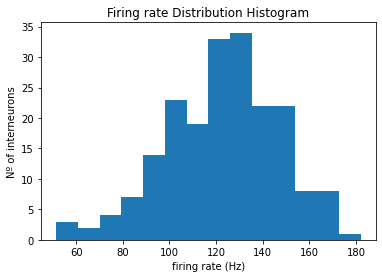

The mean of interneurons FR is 122.88571428571427Hz
The coefficient of variation of interspike-intervals is 0.24


In [58]:
cvSINt= firing_rates_dis(spikenetlong, runtimelong, 14)

#### Summery
With 6Hz of excitatory input from the Poisson Group the interneuron network exhibits synchronized oscillations with a firing rate mean around 120 Hz in the longer simulation.  We can confirm at this FR(6Hz) the interneurons act synchronously. However the frequency interval of ripples are in 140-220Hz and here the network is exhibiting a fast-gamma episode (90-140Hz). Moreover, in the longer simulation the FR mean stablises in a lower value. This phenomena could be representing the IFA (intraripple frequency accomodation that the paper talks about).
This coefficient of variation of the inter-spike interval is directly related with this asyncronic behaviour explining its higher value in longer simulations.

## Task 3: Varying the excitatory drive
Repeat task 2 but change the Poisson firing rates of the excitatory input population to

(a) 16 Hz

(b) 2 Hz

How do the network dynamics change?

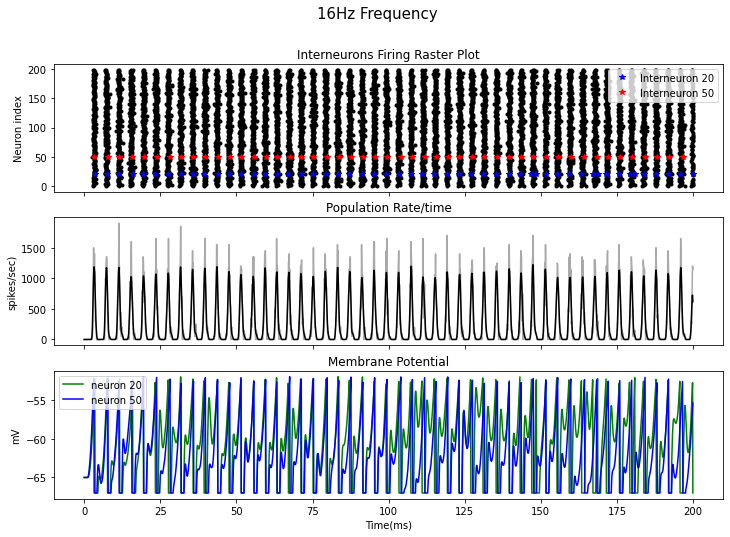

In [42]:
#a)
statenet16, spikenet16, ratenet16, runtime, frate16 = network(200, 8000, 16, 200)
sixteenHzFRnt = plotting(statenet16, spikenet16, ratenet16, runtime, frate16)

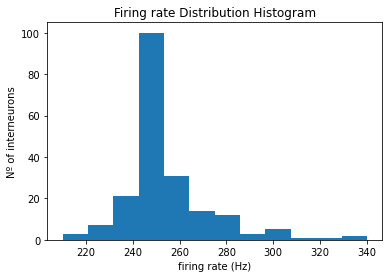

The mean of interneurons FR is 253.2Hz
The coefficient of variation of interspike-intervals is 0.07


In [49]:
cvSINt16= firing_rates_dis(spikenet16, runtime, 12)

#### How do the network dynamics change?
For a higher FR of the excitatory input (16Hz) the interneuron network exhibits fully synchronized oscillations corresponding with hippocampus ripples. The FR mean is exceeding the 240Hz higher bound of the ripples frequency interval the paper mention (140-220 Hz), smaller excitatory input rate is sufficent for achiving these ripples. Moreover, the cv of the interspike-intervals reduces due to this higher synchronicity. 

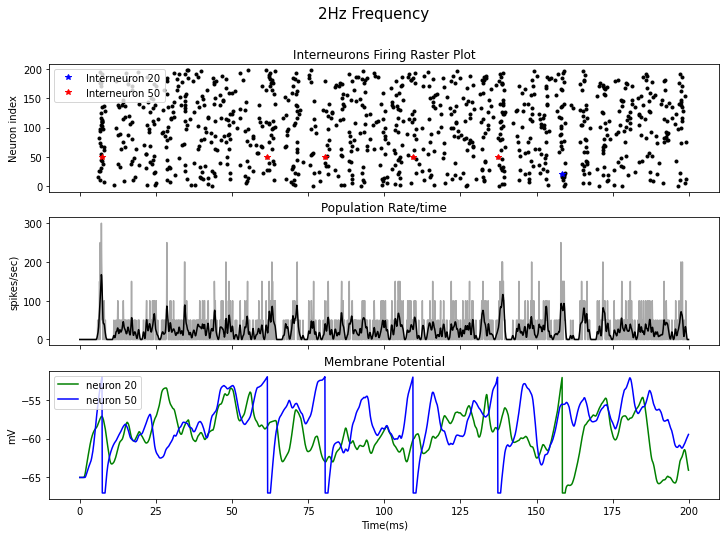

In [24]:
#b)
statenet2, spikenet2, ratenet2, runtime, frate2 = network(200, 8000, 2, 200)
twoHzFRnt = plotting(statenet2, spikenet2, ratenet2, runtime, frate2)

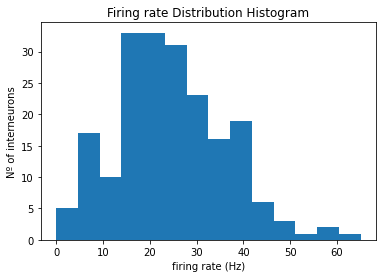

WARNING    /Users/gonuni/opt/anaconda3/envs/brian2/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
 [py.warnings]


The mean of interneurons FR is 23.925Hz
The coefficient of variation of interspike-intervals is 0.84


In [46]:
cvSINt2= firing_rates_dis(spikenet2, runtime, 14)

#### How do the network dynamics change?
For low FR of the excitatory input (2Hz) the interneuron network exhibits sparsel synchronized oscillations. A CV >0.5 corresponds to a high-noise state of the network with units fire irregularly.

The amount of excitatory drive can modulate the oscillatory state of our interneuron network. At low input rates, the network expresses sparsely synchronized oscillations. With high input rates, the network transits towards a fully synchronized regime.
Therefore, we can conclude synchronization depends on the excitatoy input rate.

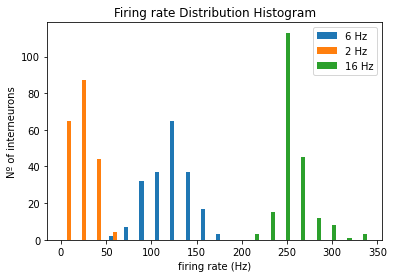

In [44]:
spikenetjoin = spikenet, spikenet2, spikenet16
Ninter = 200
frates = ['6 Hz', '2 Hz', '16 Hz']
def firing_rates_dis_join(spikenet, runtime, nbins, Ninter, frates):
    #plotting an histogram for visualize interneuron's firing rate distribution
    INfrjoin = []*Ninter*len(spikenet)
    for i in range(len(spikenet)):
        INfr = spikenet[i].count/runtime
        INfrjoin.append(INfr*1000)
    plt.hist(INfrjoin , bins = nbins, label = frates )
    plt.gca().set(title = 'Firing rate Distribution Histogram', xlabel= 'firing rate (Hz)', ylabel='Nº of interneurons')
    plt.legend()
    plt.show()
    

cvSINtjoin= firing_rates_dis_join(spikenetjoin, runtime, 20, 200, frates)


Here we can observe the distribution of the 3 simulations with different excitatory input rate

## Task 4: Reading
Read the paper by Donoso et al. (2018). 
It is a long paper, so you can focus mainly on the introduction and the first 3 pages of the Results and Figure 1. What kinds of oscillations in what brain area does this model attempt to explain? What is the potential functional role of these oscillations? <br>
Later on in the paper, how do the authors use the model to understand the effect of GABA modulators?

### Paper comprehension and questions
The paper focus in explaning the relaying mechanism of Hippocampal ripples for memory consolidation. 

There is two possible mechanisms one direct via Schaffer collaterals providing input from CA3 to CA1 in the Hippocampus and another indirect via local pyramidal cells in CA1. The direct leads to ripples and the indirect to the fast-gamma episodes both performed by the same interneuron network. Ripples are generated during deep sleep for hippocampus-dependent memory consolidation while gamma oscillations occur during locomotor activities at which sensory information is temporarily stored in the hippocampus.

Regarding the effect of GABA modulators and the in silico simulations with the model, authors wanted to check the "in vivo" observations of the GABA modulators on the ripple frequency; "The oscillation frequency of ripples in vitro is remarkably resistant to drugs that alter the time constant and peak conductance of GABAergic synaptic transmission". For that they simulate the action of the drug by modifying the peak conductance and the decay time constant of inhibitory conductances. Authors concluded that the efect of simulated GABAergic modulators confirmed the experimental results. Their model explained why drugs that induce an increase in decay time constant of GABAergic synaptic transmission can reduce ripple duration and interneuron firing rates without affecting ripple frequency.

## Bonus: 
Derive analytically the ODEs that you were given above for the numerical integration of the conductance (see Task 0).

Hint: Start by taking the derivative of the analytical expression for $g(t)$ given a single spike.

## References
Donoso, Schmitz, Maier, Kempter, "Hippocampal ripple oscillations and inhibition-first network models: Frequency dynamics and response to GABA modulators", J Neurosci, 2018

Brunel, Hakim, "Fast Global Oscillations in Networks of Integrate-and-Fire Neurons with Low Firing Rates", Neural Comput, 1999